In [13]:
import numpy as np                 # Numpy: módulo fundamental de python para poder operar
import matplotlib.pyplot as plt    # Para poder pintar gráficas
%matplotlib inline
import os
import librosa 
import librosa.display
import IPython.display


fpaths = []       # fpaths:  'audio/apple/apple07.wav'  array path de carpeta 'audio'
labels = []       # labels: array palabras repetidas (7 veces apple, 7 veces kiwi.. etc)
spoken = []       # spoken: array palabras (no repetidas)
all_obs = []

for f in os.listdir("audio"): 
    
    if f not in ".DS_Store":
        for w in os.listdir("audio/" + f):
            fpaths.append("audio/" + f + '/' + w)
            labels.append(f)
            if f not in spoken:
                spoken.append(f)
                
print 'Words spoken:', spoken

from scipy.io import wavfile

data = np.zeros((len(fpaths), 32000))

print 'Number of files total:', data.shape[0]

all_labels = np.zeros(data.shape[0])     #Conseguimos una matriz de 105 elementos rellenados con 0 (np.zeros)
print
print 'Matriz all_labels comienzo: ', all_labels


for n, l in enumerate(set(labels)):
    all_labels[np.array([i for i, _ in enumerate(labels) if _ == l])] = n   

print
print 'Matriz etiquetada : ', all_labels


maxsize = -1
for n,file in enumerate(fpaths): 
    
    x, fs = librosa.load(file, sr=8000)
    data[n, :x.shape[0]] = x  
    if x.shape[0] > maxsize:
        maxsize = x.shape[0]
        
data = data[:, :maxsize]


for n,file in enumerate(fpaths):  
    
    mfccs = librosa.feature.mfcc(data[n,:], sr=8000, n_mfcc=20)
    print(mfccs.shape)  #Va cogiendo los 20 mfcc de cada audio
    
    all_obs.append(mfccs)    # Añadimos los mfcc
   
    if n % 10 == 0:
        print("Processed obs %s" % n)
        #print obs
    

all_obs = np.atleast_3d(all_obs)


print
print 'Matriz Resultante : ', all_obs.shape

print


Words spoken: ['apple', 'kiwi', 'lime', 'banana', 'pineapple', 'orange', 'peach']
Number of files total: 105

Matriz all_labels comienzo:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Matriz etiquetada :  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2.]
(20, 14)
Processed obs 0
(20, 14)
(20, 14)
(20, 14)
(20, 14)
(20, 14)
(20, 14)
(20, 14)
(20, 14)
(20, 14)
(20, 14)
Processed obs 10
(20, 14)
(20, 14)
(20, 14)
(20, 14)
(20, 14)
(20, 14)
(20, 14)
(2

Dividimos la matriz en test y train: 

In [61]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0)


for n,i in enumerate(all_obs):
    all_obs[n] /= all_obs[n].sum(axis=0)

for train_index, test_index in sss.split(all_obs, all_labels):
    x_train, x_test = all_obs[train_index, ...], all_obs[test_index, ...]
    y_train, y_test = all_labels[train_index], all_labels[test_index]
print('Size of training matrix:', x_train.shape)

print('Size of testing matrix:', x_test.shape)

('Size of training matrix:', (52, 20, 14))
('Size of testing matrix:', (53, 20, 14))


----------------------------------
   REDES NEURONALES
----------------------------------

Utilizaremos Keras que es una librería de alto nivel, para que nos sea más fácil describir las capas de la red que creamos.
En background, es decir, el motor que ejecutará la red neuronal y la entrenará será la implementación llamada Tensorflow, que es la mejor que existe hoy en día.

Utilizaremos numpy para el manejo de arrays. 

De Keras importamos el tipo de modelo Sequential y el tipo de capa Dense que es la «normal».

In [72]:
# Normalizamos matriz: 

import tensorflow.keras as keras

import tensorflow as tf

import numpy



# Fix random seed for reproducibility.
# seed = 7
# numpy.random.seed(seed)

x_train = tf.keras.utils.normalize(x_train, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)


In [73]:
# * * * * * * * * * * * * * * * * * * * *
#                                       
#          MODELO SECUENCIAL 
#    (las cosas, secuencias van a ir 
#        en orden directo)
#
# * * * * * * * * * * * * * * * * * * * *


# Primero creamos un modelo vació de tipo Sequential. 
# Este modelo se refiere a que crearemos una serie de capas de neuronas secuenciales, «una delante de otra».

model = tf.keras.models.Sequential()

# -------------


## Ahora vamos a rellenar las capas de nuestra red neural.
## Keras tiene un modulo para esto: flatten 

# Agregamos capas Dense con «model.add()». Realmente el numero de capas que tendremos serán, 
# estas que agregamos y la primera de Sequential

# * * * * * * * * * * * * * * * * * * * *
#                                       
#         AGREGAMOS CAPAS
#        A LA RED NEURONAL
#
# * * * * * * * * * * * * * * * * * * * *

model.add(tf.keras.layers.Flatten()) #Flatten convierte la matriz en un simple array



model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))    # Capa oculta (variar nº neuronas)

model.add(tf.keras.layers.Dense(7, activation=tf.nn.softmax))   # Capa de salida 

# -------------

# Antes de de entrenar la red haremos unos ajustes de nuestro modelo:

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Con esto indicamos el tipo de pérdida (loss) que utilizaremos, 
# el «optimizador» de los pesos de las conexiones de las neuronas y 
# las métricas que queremos obtener (accuracy en nuestro caso).

# -------------
# Ajustes al modelo, antes de entrenar la red neuronal.
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [74]:
# - - - - - - - - - - - - - - -  - 
# - Entrenamos a la red neuronal - 
# - - - - - - - - - - - - - - -  -

history = model.fit(x_train, y_train, epochs=8)


val_loss, val_acc = model.evaluate(x_test, y_test)
#print(val_loss)
#print(val_acc)
#print(val_acc*100)


    
print("\n%s: %.2f%%" % (model.metrics_names[1], val_acc*100))


Train on 52 samples
Epoch 1/8
52/52 [==============================] - 0s 4ms/sample - loss: 1.9592 - accuracy: 0.1346
Epoch 2/8
52/52 [==============================] - 0s 285us/sample - loss: 1.8651 - accuracy: 0.1923
Epoch 3/8
52/52 [==============================] - 0s 270us/sample - loss: 1.7873 - accuracy: 0.6538
Epoch 4/8
52/52 [==============================] - 0s 218us/sample - loss: 1.7229 - accuracy: 0.8654
Epoch 5/8
52/52 [==============================] - 0s 164us/sample - loss: 1.6617 - accuracy: 0.8846
Epoch 6/8
52/52 [==============================] - 0s 187us/sample - loss: 1.6014 - accuracy: 0.8846
Epoch 7/8
52/52 [==============================] - 0s 207us/sample - loss: 1.5464 - accuracy: 0.9038
Epoch 8/8
53/53 [==============================] - 0s 1ms/sample - loss: 1.4600 - accuracy: 0.9245

accuracy: 92.45%


In [75]:
# - - - - - - - - - - - - - - - - 
# - - - EVALUAMOS EL MODELO - - -
# - - - - - - - - - - - - - - - -

scores = model.evaluate(x_train, y_train)

print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))



val_loss, val_acc = model.evaluate(x_test, y_test)
print(val_loss)
print(val_acc)
print(val_acc*100)



    
print("\n%s: %.2f%%" % (model.metrics_names[1], val_acc*100))
#print('Test accuracy:', val_acc*100)

52/52 [==============================] - 0s 91us/sample - loss: 1.4401 - accuracy: 0.9423

accuracy: 94.23%
53/53 [==============================] - 0s 94us/sample - loss: 1.4600 - accuracy: 0.9245
1.4599714639051906
0.9245283
92.45283007621765

accuracy: 92.45%


In [76]:
classes=[0,1,2,3,4,5,6]
classes_test = ['apple', 'kiwi', 'lime','banana', 'pineapple', 'orange', 'peach']
y_pred=model.predict_classes(x_test)
con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()

In [77]:
import pandas as pd

con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
 
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes_test, 
                     columns = classes_test)



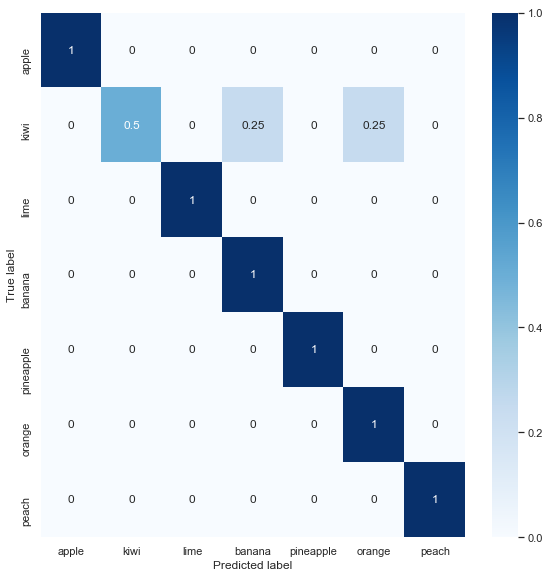

In [78]:
import seaborn as sns; sns.set()

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [79]:
# Python script for confusion matrix creation. 

from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

actual = y_test 
predicted = y_pred
results = confusion_matrix(actual, predicted) 

print 'Confusion Matrix :'
print(results) 
print 'Accuracy Score :',accuracy_score(actual, predicted) 
print 'Report : '
print classification_report(actual, predicted, target_names= spoken) 



Confusion Matrix :
[[7 0 0 0 0 0 0]
 [0 4 0 2 0 2 0]
 [0 0 8 0 0 0 0]
 [0 0 0 7 0 0 0]
 [0 0 0 0 8 0 0]
 [0 0 0 0 0 7 0]
 [0 0 0 0 0 0 8]]
Accuracy Score : 0.9245283018867925
Report : 
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00         7
        kiwi       1.00      0.50      0.67         8
        lime       1.00      1.00      1.00         8
      banana       0.78      1.00      0.88         7
   pineapple       1.00      1.00      1.00         8
      orange       0.78      1.00      0.88         7
       peach       1.00      1.00      1.00         8

   micro avg       0.92      0.92      0.92        53
   macro avg       0.94      0.93      0.92        53
weighted avg       0.94      0.92      0.92        53



#### Representacion de Matriz de confusion para el modelo

- Tasa de clasificacion/prediccion: Accuracy = (TP + TN) / (TP + TN + FP + FN)= 0.89

- Recall : nos da una idea de cuándo es realmente sí, con qué frecuencia predice sí. Recuperación = TP / (TP + FN) = 0.89

- Precision : nos dice cuándo predice sí, con qué frecuencia es correcta. Precisión = TP / (TP + FP) = 100 / (100 + 10) = 0.89

Text(0.5,0,'Predicted label')

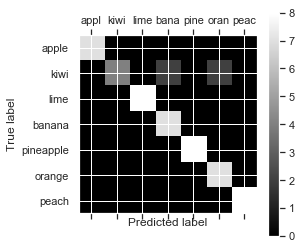

In [80]:

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(actual, predicted)
plt.matshow(cm, cmap='gray')
ax = plt.gca()
_ = ax.set_xticklabels([" "] + [l[:4] for l in spoken])
_ = ax.set_yticklabels([" "] + spoken)
#plt.title('Confusion matrix, single speaker')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')